In [1]:
import numpy as np
from PIL import Image
from torchvision import transforms as T
import torch
import requests

from transformers import ConvNextMaskRCNNForObjectDetection


model = ConvNextMaskRCNNForObjectDetection.from_pretrained("nielsr/convnext-tiny-maskrcnn")

url = "https://miro.medium.com/max/1000/0*w1s81z-Q72obhE_z"
image = Image.open(requests.get(url, stream=True).raw)

# standard PyTorch mean-std input image normalization
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

pixel_values = transform(image).unsqueeze(0)

width, height = image.size
pixel_values_height, pixel_values_width = pixel_values.shape[-2:]
width_scale = pixel_values_width / width
height_scale = pixel_values_height / height

img_metas = [
    dict(
        img_shape=tuple(pixel_values.shape[2:]) + (3,),
        scale_factor=np.array([width_scale, height_scale, width_scale, height_scale], dtype=np.float32),
        ori_shape=(height, width, 3),
    )
]

# forward pass
with torch.no_grad():
    outputs = model(pixel_values, img_metas=img_metas)
    bbox_results = outputs.results[0][0]

detections = []
for label in range(len(bbox_results)):
  if len(bbox_results[label]) > 0:
    for detection in bbox_results[label]:
      detections.append((label, detection))
for det in detections:
  print("Detected:", det)

RPN classification logits:
torch.Size([3, 200, 299])
torch.Size([3, 100, 149])
torch.Size([3, 50, 74])
torch.Size([3, 25, 37])
torch.Size([3, 13, 19])
RPN bounding box predictions:
torch.Size([12, 200, 299])
torch.Size([12, 100, 149])
torch.Size([12, 50, 74])
torch.Size([12, 25, 37])
torch.Size([12, 13, 19])
Shape of RPN result: torch.Size([1000, 5])
Proposal list:
torch.Size([1000, 5])
Detected boxes: [tensor([[2.0328e+02, 9.9555e+01, 2.7427e+02, 2.5207e+02, 9.9941e-01],
        [1.9893e+02, 1.8155e+02, 2.2540e+02, 2.3708e+02, 9.8529e-01],
        [2.2651e+02, 2.4805e+02, 2.6710e+02, 2.6382e+02, 9.7993e-01],
        [8.1670e+01, 1.4877e+02, 1.1114e+02, 1.5946e+02, 8.8920e-01],
        [4.4807e+01, 1.5396e+02, 9.4318e+01, 1.6996e+02, 6.8737e-01],
        [1.2128e+02, 1.4433e+02, 1.4286e+02, 1.5718e+02, 5.3399e-01],
        [0.0000e+00, 1.6747e+02, 1.8806e+01, 1.9587e+02, 4.8384e-01],
        [4.5729e+00, 1.6686e+02, 4.6005e+01, 1.9494e+02, 4.6296e-01],
        [3.9249e+01, 1.5997e+02, 

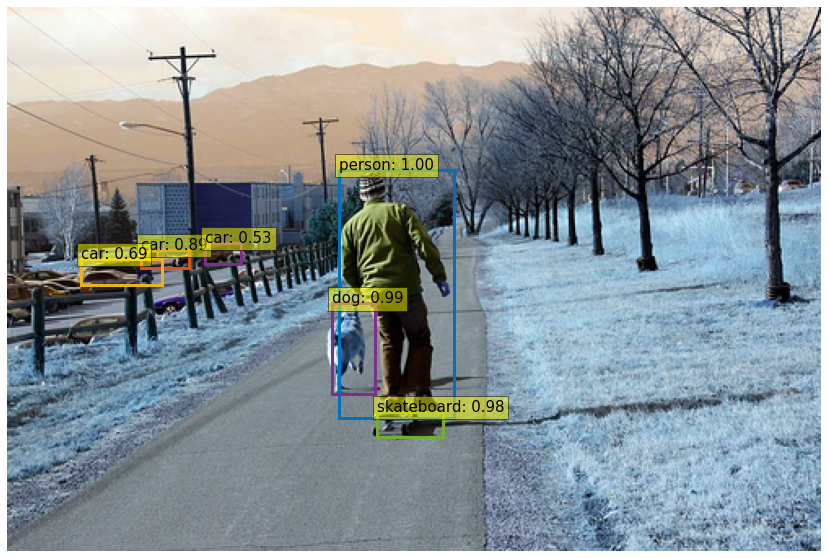

In [2]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, detections):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for detection, color in zip(detections, colors):
        cl = detection[0]
        (xmin, ymin, xmax, ymax) = detection[1][:-1]
        score = detection[1][-1]
        if score < 0.5:
          continue
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=color, linewidth=3))
        text = f'{model.config.id2label[cl]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(image, detections)